In [216]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
# Colab 폴더로 경로 이동
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning

/content/drive/MyDrive/Colab Notebooks/DeepLearning


# CiFAR 이미지 분류 모델 구현
---
- 데이터: CiFAR10 https://www.cs.toronto.edu/~kriz/cifar.html
- 학습방법: 10가지 이미 종류 분류 => 다중분류
- 이미지: DNN(MLP),CNN적용

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets.cifar10 import load_data

In [219]:
# W,b 고정하도록 seed 설정
set_random_seed(42)

# [1] 데이터 준비 및 로딩
---

In [220]:
(x_train, y_train), (x_test,y_test) = load_data()

In [221]:
print(f'x_train.shape : {x_train.shape}, y_train.shape : {y_train.shape}')
print(f'x_test.shape : {x_test.shape}, y_test.shape : {y_test.shape}')

x_train.shape : (50000, 32, 32, 3), y_train.shape : (50000, 1)
x_test.shape : (10000, 32, 32, 3), y_test.shape : (10000, 1)


# [2] 데이터 전처리 및 학습형태로 변환
---

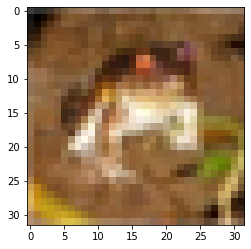

In [222]:
plt.imshow(x_train[0])
plt.show()

In [223]:
# 스케일링 => 픽셀 / 255.0
x_train = x_train/255.0
x_test = x_test/255.0

In [224]:
# Conv 레이어는 이미지의 채널정보까지 입력해야함 (,,,1)
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

In [225]:
print(f'x_train.shape : {x_train.shape}')
print(f'x_test.shape : {x_test.shape}')

x_train.shape : (50000, 32, 32, 3)
x_test.shape : (10000, 32, 32, 3)


In [226]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify= y_train, random_state=42)

In [227]:
print(f'x_train.shape : {x_train.shape}')
print(f'x_val.shape : {x_val.shape}')
print(f'x_test.shape : {x_test.shape}')

x_train.shape : (37500, 32, 32, 3)
x_val.shape : (12500, 32, 32, 3)
x_test.shape : (10000, 32, 32, 3)


## [3-1] 모델 구상

In [228]:
model = Sequential()

In [229]:
# 이미지 특징 추출 Layer => 첫번째 입력값 설정
model.add(Conv2D(32,kernel_size = (3,3), 
                 padding = 'same', 
                 input_shape = (32,32,3),
                 activation = 'relu'))
model.add(Conv2D(32, (3, 3),activation = 'relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),activation = 'relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, (3, 3),activation = 'relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation = 'softmax'))
# 커널 1개, 사이즈 3 -> 3x3 +1(바이어스) => Param =10
# padding 속성 same이 아니면 노드 숫자가 줄어듬.

In [230]:
# # 이미지 특징 다운샘플링 layer => MaxPool2D
# model.add(MaxPool2D()) #연산은 안하기 때문에 Params = 0

In [231]:
## 1차원으로 데이터 형태 변환 Layer => Flatten
# model.add(Flatten())

In [232]:
# # 출력층 => Node : 10개(0~9), activation : softmax
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(10, activation = 'softmax'))

In [233]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                 

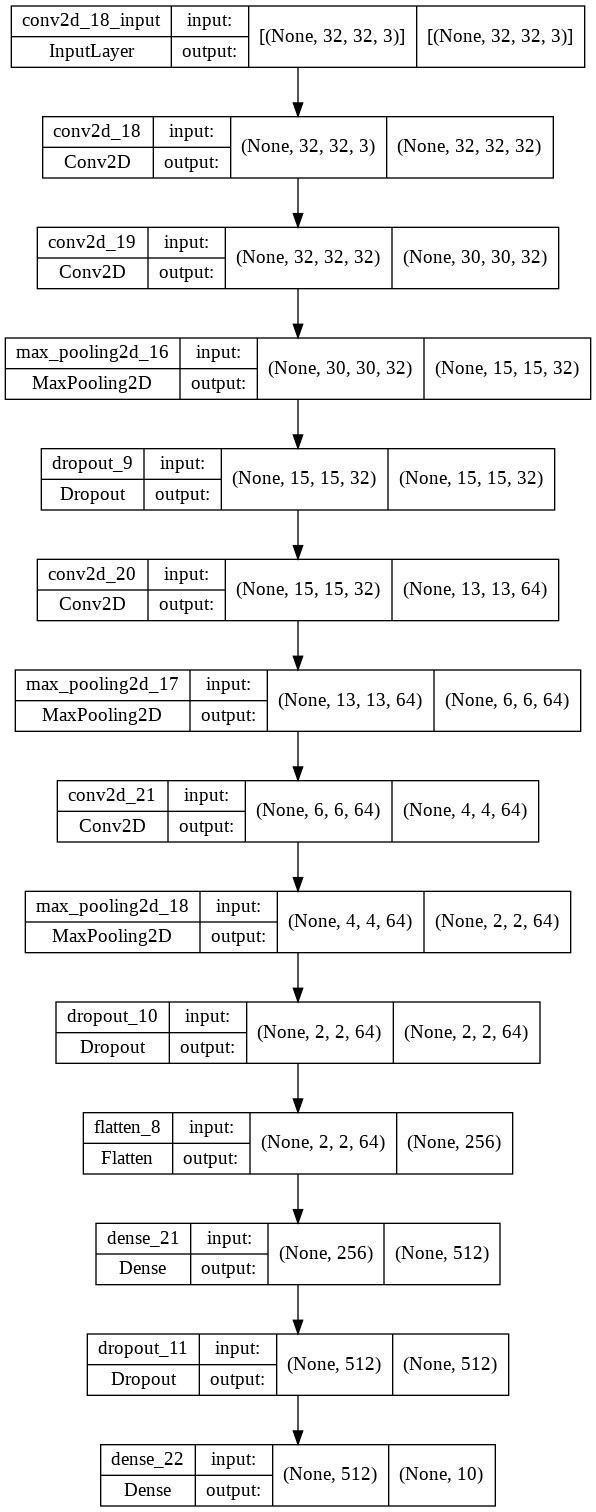

In [234]:
plot_model(model,show_shapes=True)

## [3-2] 모델 생성
---
- compile메서드
  - loss 손실 함수 => sparse_categorical_crossentropy
  - optimizer 최적화 방식 => adam
  - metrics 평가항목 => accuracy

In [235]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'sgd',
              metrics = 'accuracy')

## [3-3] 모델 학습
  - fit메서드
    - 학습 데이터, 라벨
    - epochs 학습횟수
    - batch_size 학습분량
    - validation_data 검증데이터, 검증라벨
    - validation_split 학습데이터의 일부 비율 설정(ex:0.2)
    - callback
    - verbose : 학습 진행도 화면 출력 여부 설정

In [236]:
# EarlyStopping 생성 (callbacks)
stopCB = EarlyStopping(monitor = 'accuracy', patience = 3)

In [237]:
his = model.fit(x_train, y_train, 
                epochs = 100, 
                validation_data = (x_val,y_val),
                callbacks=[stopCB])

Epoch 1/100
1172/1172 [==============================] - 7s 6ms/step - loss: 2.2495 - accuracy: 0.1456 - val_loss: 2.0678 - val_accuracy: 0.2198
Epoch 2/100
1172/1172 [==============================] - 6s 5ms/step - loss: 1.9759 - accuracy: 0.2566 - val_loss: 1.8174 - val_accuracy: 0.3337
Epoch 3/100
1172/1172 [==============================] - 6s 5ms/step - loss: 1.8080 - accuracy: 0.3267 - val_loss: 1.8868 - val_accuracy: 0.3389
Epoch 4/100
1172/1172 [==============================] - 6s 5ms/step - loss: 1.6862 - accuracy: 0.3770 - val_loss: 1.5300 - val_accuracy: 0.4468
Epoch 5/100
1172/1172 [==============================] - 6s 5ms/step - loss: 1.5875 - accuracy: 0.4123 - val_loss: 1.5073 - val_accuracy: 0.4610
Epoch 6/100
1172/1172 [==============================] - 6s 5ms/step - loss: 1.5160 - accuracy: 0.4438 - val_loss: 1.4163 - val_accuracy: 0.4911
Epoch 7/100
1172/1172 [==============================] - 6s 5ms/step - loss: 1.4476 - accuracy: 0.4704 - val_loss: 1.3213 - val_ac

학습 진행 결과 시각화

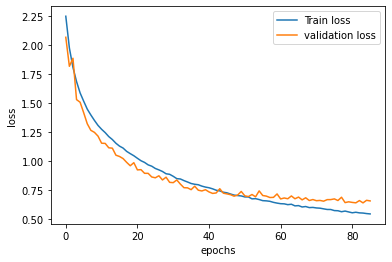

In [238]:
# loss 비교
plt.plot(his.epoch, his.history['loss'],label='Train loss')
plt.plot(his.epoch, his.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

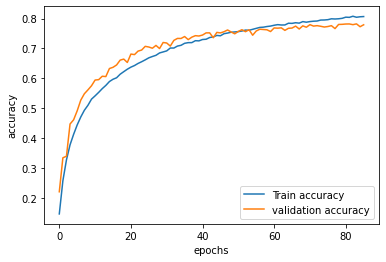

In [239]:
# accuracy
plt.plot(his.epoch, his.history['accuracy'],label='Train accuracy')
plt.plot(his.epoch, his.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## [4] 평가
---
- evaluate()
- 테스트 데이터, 테스트 라벨

In [240]:
pre_y = model.predict(x_test)

# [5] 테스트
---

In [241]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6652 - accuracy: 0.7778


[0.6652317047119141, 0.7778000235557556]